## FastSAM 能力验证

导入相关的包

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

data_model_dir = '/home/scc/Downloads/AIToy/P3_Segment_Anything/2.fastsam_demo'

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2], box[3]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## 测试图片

In [3]:
image = cv2.imread(f'{data_model_dir}/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

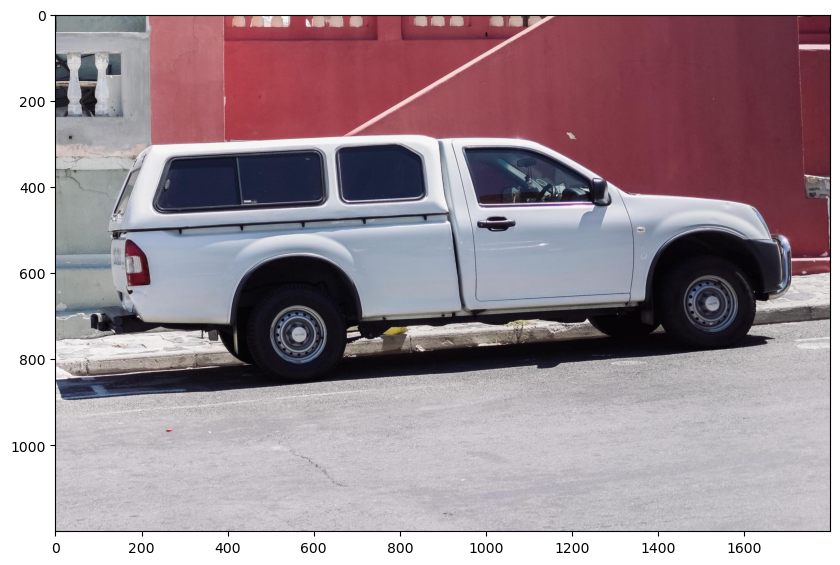

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 使用FastSAM分割

In [5]:
from fastsam import FastSAM, FastSAMPrompt
# 模型权重文件
sam_checkpoint = f"{data_model_dir}/FastSAM-x.pt"

# 加载模型
model = FastSAM(sam_checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
IMAGE_PATH = f'{data_model_dir}/images/truck.jpg'
# 相当于SAM的image embedding
everything_results = model(IMAGE_PATH, device=device, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)

In [8]:
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=device)

In [9]:
# 选择一个点 (x, y) 作为输入
input_point = np.array([[500, 375]])
# 标注这个点的类别，1 表示foreground，即前景点，0 表示background，即背景点
input_label = np.array([1])

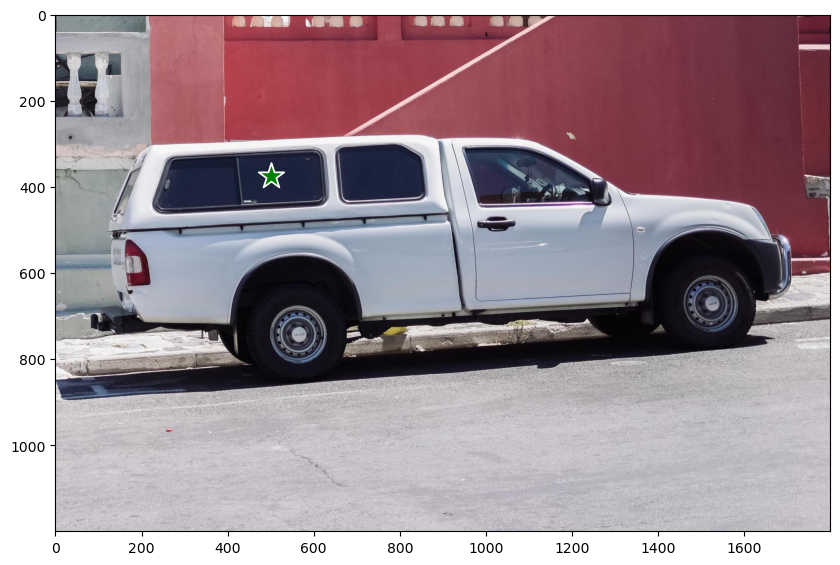

In [10]:
# 绘制检查一下
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [11]:
ann = prompt_process.point_prompt(points=input_point, pointlabel=input_label)

In [12]:
#  (number_of_masks) x H x W
ann.shape

(1, 1200, 1800)

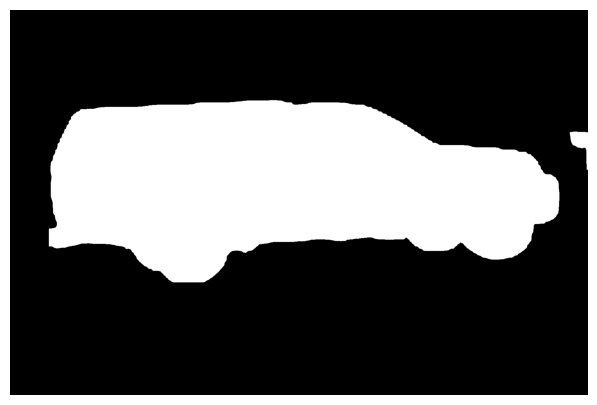

In [13]:
# 分别显示1个mask
plt.figure(figsize=(15,5))
plt.imshow(ann[0], cmap='gray')
plt.axis('off')
plt.show()

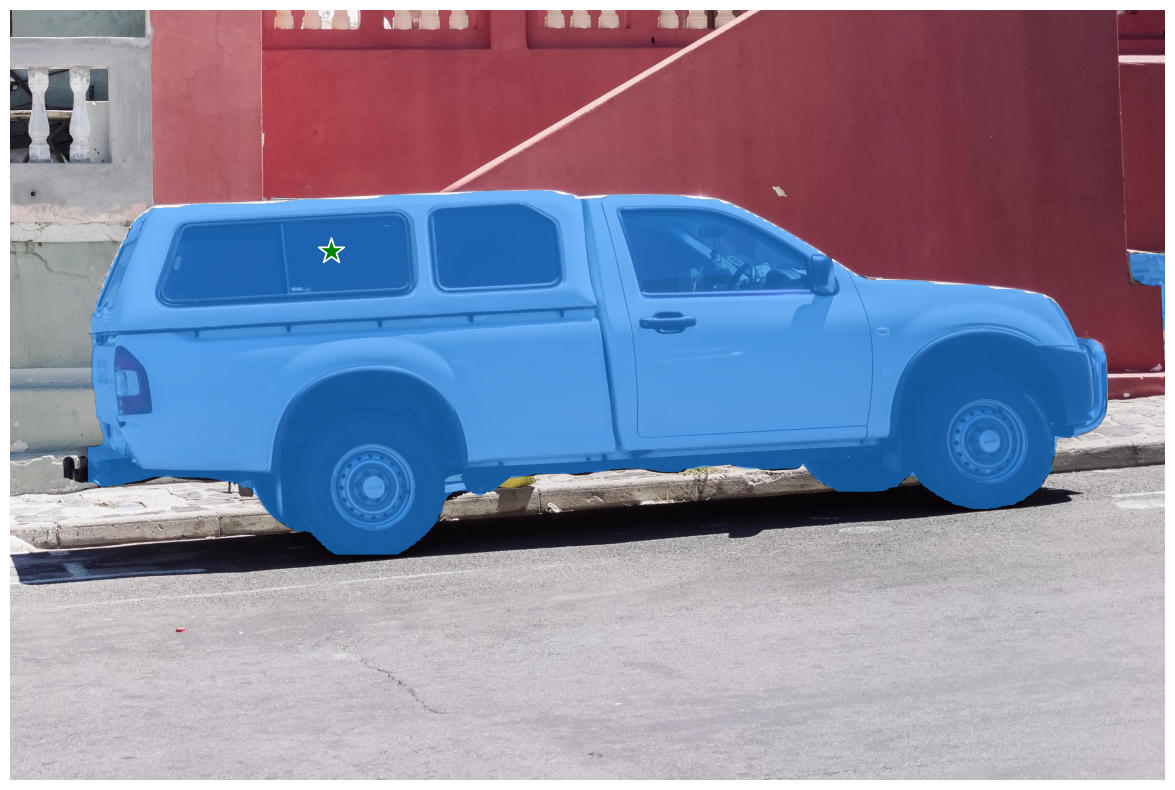

In [14]:
# 将结果绘制在图像上
plt.figure(figsize=(20,10))
plt.imshow(image)
show_mask(ann[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## 使用更多点确定目标

In [15]:
# 输入的2个点坐标
input_point = np.array([[500, 375], [1125, 625]])
# 都是1，表示都是正样本
input_label = np.array([1, 1])

In [16]:
ann = prompt_process.point_prompt(points=input_point, pointlabel=input_label)

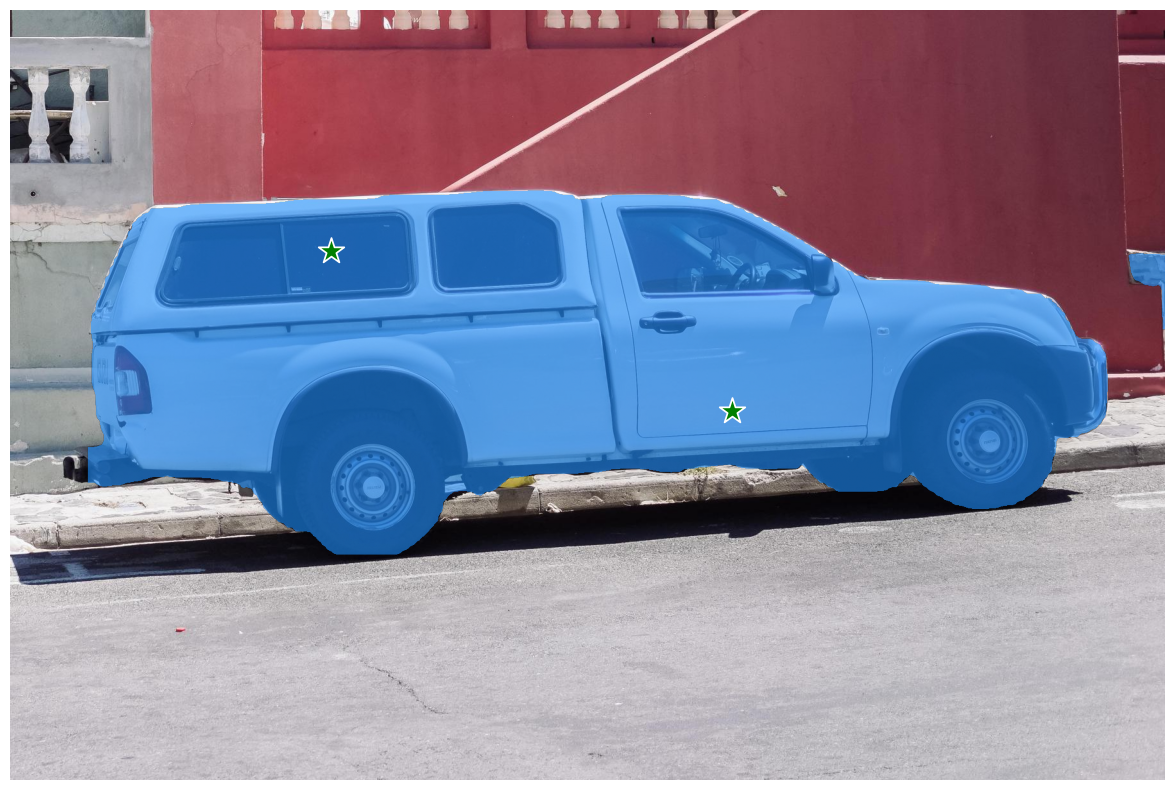

In [17]:
# 将结果绘制在图像上
plt.figure(figsize=(20,10))
plt.imshow(image)
show_mask(ann[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

  

In [18]:
# 如果只想要玻璃而不要车身，可以将第二个点的label改为0
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])


In [19]:
ann = prompt_process.point_prompt(points=input_point, pointlabel=input_label)

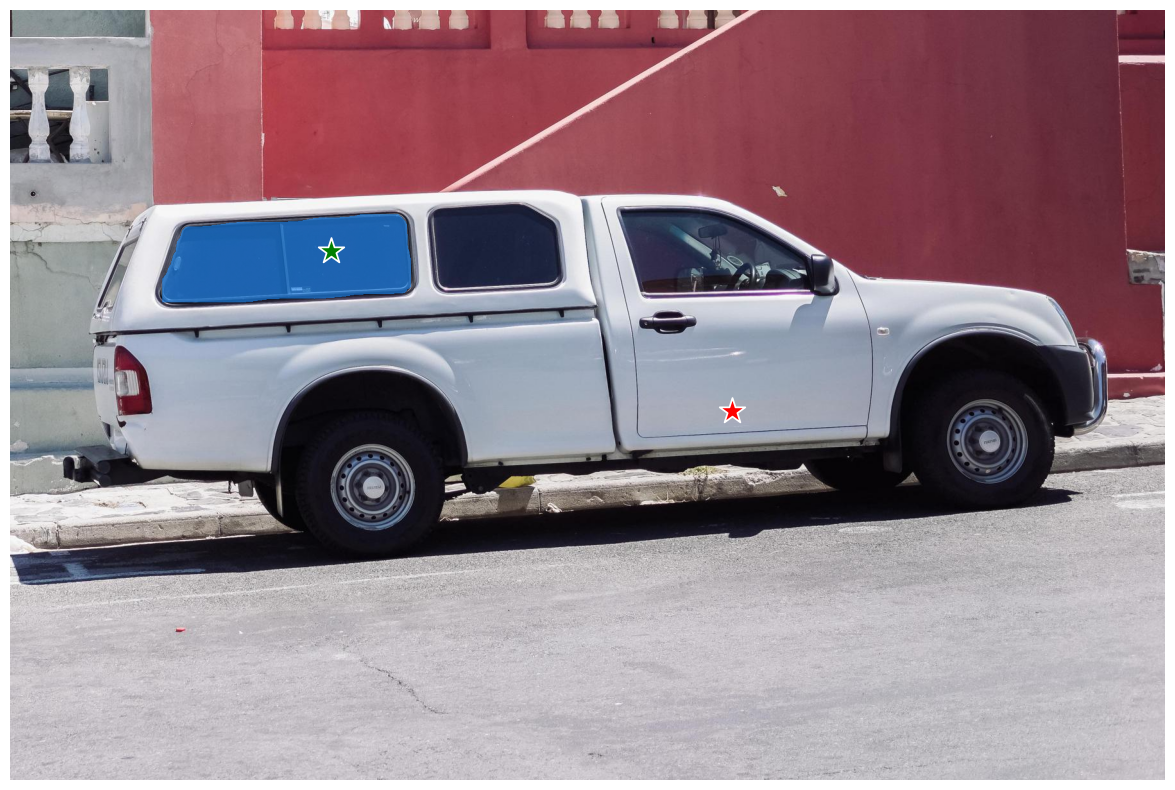

In [20]:
# 将结果绘制在图像上
plt.figure(figsize=(20,10))
plt.imshow(image)
show_mask(ann[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

  

## 使用矩形框作为提示

In [21]:
# 矩形框坐标：l, t, w, h
input_box = [425, 600, 700-425, 875-600]

In [22]:
ann = prompt_process.box_prompt(bbox=input_box)

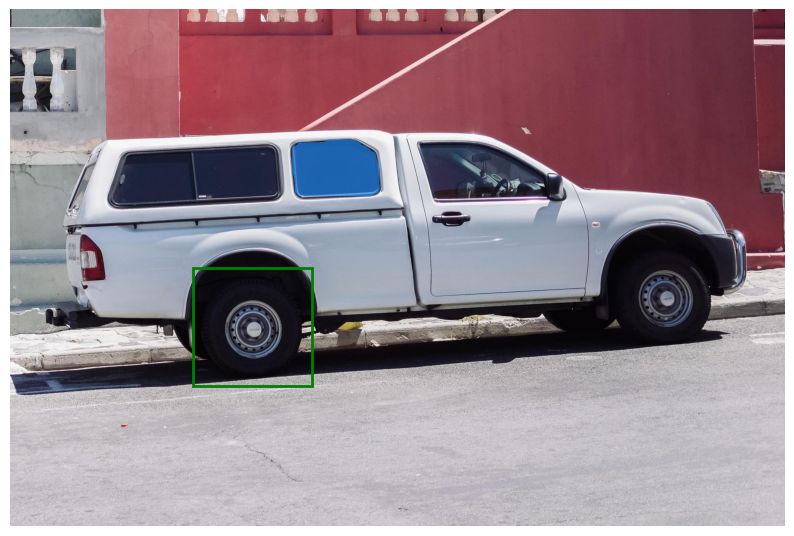

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(ann[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()